# Compare today's matter power spectra for PM, BullFrog 🐸 and COLA

Tristan Hoellinger<br/>
Institut d'Astrophysique de Paris</br>
tristan.hoellinger@iap.fr

In [ ]:
from os.path import isfile
from pathlib import Path
import numpy as np

from pysbmy.power import PowerSpectrum
from pysbmy.fft import FourierGrid, read_FourierGrid
from pysbmy.field import read_field
from pysbmy.correlations import get_autocorrelation
from pysbmy.timestepping import BullFrogTimeStepping

from plot_utils import *

## Set up the environment

In [2]:
WORKDIR = "/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_params/"
SIMDIR = "/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_sims/"  # need not be on same disk

In [3]:
from tools import generate_sim_params, generate_white_noise_Field
from params import cosmo, cosmo_small_to_full_dict, z2a, BASELINE_SEEDPHASE

L = 250.0
corner = -125.0
N = 64
Np = 64
Npm = 64
RedshiftLPT = 19.0
RedshiftFCs = 0.0
ai = z2a(RedshiftLPT)
af = z2a(RedshiftFCs)

## Prepare the inputs

### Define the list of simulations to perform for this run

In [4]:
run_id = "run1"
force = False

# Parameters for the pm simulations
nsteps_pm_list = [20]

# Parameters for the cola simulations
nsteps_cola_list = [2, 5, 10]

# Parameters for the cola simulations
nsteps_bullfrog_list = [2, 5, 10]

In principle nothing needs to be changed below this cell.

In [5]:
wd = WORKDIR + run_id + "/"
simdir = SIMDIR + run_id + "/"
logdir = simdir + "logs/"
Path(wd).mkdir(parents=True, exist_ok=True)
Path(logdir).mkdir(parents=True, exist_ok=True)

nsim_pm = len(nsteps_pm_list)
nsim_cola = len(nsteps_cola_list)
nsim_bullfrog = len(nsteps_bullfrog_list)

input_white_noise_file = simdir + "input_white_noise.h5"
input_seed_phase_file = simdir + "seed"
ICs_path = simdir + "initial_density.h5"
simpath = simdir

In [6]:
# Path to the input matter power spectrum (generated later)
input_power_file = simdir + "input_power.h5"

### Generate the parameter files

The first preparatory step is to generate all the parameter files required for all the simulations.

To this end we use the `generate_sim_params` function defined in `params.py`.

In [7]:
common_params = {
    "Np0": Np,
    "N0": N,
    "L0": L,
    "corner0": corner,
    "corner1": corner,
    "corner2": corner,
    "h": cosmo["h"],
    "Omega_m": cosmo["Omega_m"],
    "Omega_b": cosmo["Omega_b"],
    "n_s": cosmo["n_s"],
    "sigma8": cosmo["sigma8"],
}

lpt_params = common_params.copy()
lpt_params["method"] = "lpt"
lpt_params["InputPowerSpectrum"] = input_power_file
lpt_params["ICsMode"] = 1
# 0 : the codes generates white noise, then initial conditions
# 1 : external white noise specified, the code multiplies by the power spectrum
# 2 : external initial conditions specified
lpt_params["InputWhiteNoise"] = input_white_noise_file

pm_params = common_params.copy()
pm_params["method"] = "pm"
pm_params["TimeStepDistribution"] = 0
pm_params["ai"] = ai
pm_params["af"] = af
pm_params["RedshiftLPT"] = RedshiftLPT
pm_params["RedshiftFCs"] = RedshiftFCs
pm_params["Npm0"] = Npm

cola_params = common_params.copy()
cola_params["method"] = "cola"
cola_params["TimeStepDistribution"] = 0
cola_params["ai"] = ai
cola_params["af"] = af
cola_params["RedshiftLPT"] = RedshiftLPT
cola_params["RedshiftFCs"] = RedshiftFCs
cola_params["Npm0"] = Npm

bullfrog_params = common_params.copy()
bullfrog_params["method"] = "bullfrog"
bullfrog_params["TimeStepDistribution"] = 0
bullfrog_params["ai"] = ai
bullfrog_params["af"] = af
bullfrog_params["RedshiftLPT"] = RedshiftLPT
bullfrog_params["RedshiftFCs"] = RedshiftFCs
bullfrog_params["Npm0"] = Npm

> Generating parameter file...
[18:13:14|STATUS    ]|Writing parameter file in '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_params/run1/example_lpt.sbmy'...
[18:13:14|STATUS    ]|Writing parameter file in '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_params/run1/example_lpt.sbmy' done.
> Parameter file written to /data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_params/run1/example_lpt.sbmy.
PM nsteps = 20:
> Generating time-stepping distribution...
[18:13:14|STATUS    ]|Write timestepping configuration in '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_params/run1/nsteps20_ts_pm.h5'...
[18:13:14|STATUS    ]|Write timestepping configuration in '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_params/run1/nsteps20_ts_pm.h5' done.
> Generating parameter file...
[18:13:14|STATUS    ]|Writing parameter file in '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_pa

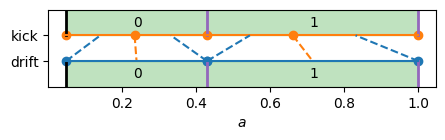

BULLFROG nsteps = 5:
> Generating time-stepping distribution...
[18:13:19|STATUS    ]|Write timestepping configuration in '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_params/run1/nsteps5_ts_bullfrog.h5'...
[18:13:19|STATUS    ]|Write timestepping configuration in '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_params/run1/nsteps5_ts_bullfrog.h5' done.
> Generating parameter file...
[18:13:19|STATUS    ]|Writing parameter file in '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_params/run1/nsteps5_example_bullfrog.sbmy'...
[18:13:19|STATUS    ]|Writing parameter file in '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_params/run1/nsteps5_example_bullfrog.sbmy' done.
> Parameter file written to /data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_params/run1/nsteps5_example_bullfrog.sbmy.
[18:13:19|STATUS    ]|Read timestepping configuration in '/data101/hoellinger/BullFrog/comparison

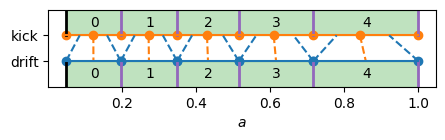

BULLFROG nsteps = 10:
> Generating time-stepping distribution...
[18:13:21|STATUS    ]|Write timestepping configuration in '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_params/run1/nsteps10_ts_bullfrog.h5'...
[18:13:21|STATUS    ]|Write timestepping configuration in '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_params/run1/nsteps10_ts_bullfrog.h5' done.
> Generating parameter file...
[18:13:21|STATUS    ]|Writing parameter file in '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_params/run1/nsteps10_example_bullfrog.sbmy'...
[18:13:21|STATUS    ]|Writing parameter file in '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_params/run1/nsteps10_example_bullfrog.sbmy' done.
> Parameter file written to /data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_params/run1/nsteps10_example_bullfrog.sbmy.
[18:13:21|STATUS    ]|Read timestepping configuration in '/data101/hoellinger/BullFrog/comp

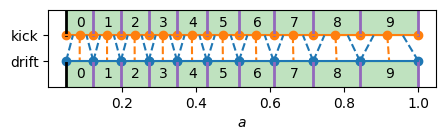

In [8]:
# generate_sim_params(lpt_params, ICs_path, wd, simdir, None, force)

# for i in range(nsim_pm):
#     print(f"PM nsteps = {nsteps_pm_list[i]}:")
#     pm_params["nsteps"] = nsteps_pm_list[i]
#     file_ext = f"nsteps{nsteps_pm_list[i]}"  # "pm" is already in the filename
#     generate_sim_params(pm_params, ICs_path, wd, simdir, file_ext, force)

# for i in range(nsim_cola):
#     print(f"COLA nsteps = {nsteps_cola_list[i]}:")
#     cola_params["nsteps"] = nsteps_cola_list[i]
#     file_ext = f"nsteps{nsteps_cola_list[i]}"  # "cola" is already in the filename
#     generate_sim_params(cola_params, ICs_path, wd, simdir, file_ext, force)

for i in range(nsim_bullfrog):
    print(f"BULLFROG nsteps = {nsteps_bullfrog_list[i]}:")
    bullfrog_params["nsteps"] = nsteps_bullfrog_list[i]
    file_ext = f"nsteps{nsteps_bullfrog_list[i]}"  # "bullfrog" is already in the filename
    generate_sim_params(bullfrog_params, ICs_path, wd, simdir, file_ext, force)
    BullFrogTimeStepping.read(wd + file_ext+"_ts_bullfrog.h5").plot()

### Generate the initial phase

In [9]:
generate_white_noise_Field(
    seedphase=BASELINE_SEEDPHASE,
    fname_whitenoise=input_white_noise_file,
    seedname_whitenoise=input_seed_phase_file,
    N=N,
    L=L,
    corner=corner,
    force_phase=False,
)

### Generating the input power spectrum

The second preparatory step is to compute the initial power spectrum to be used in the simulations, given the cosmological parameters and prescription specified in ``params.py``. The power spectrum is saved in `input_power_file`.

In [10]:
# If cosmo["WhichSpectrum"] == "class", then the module classy is required.
if not isfile(input_power_file):
    Pk = PowerSpectrum(L, L, L, N, N, N, cosmo_small_to_full_dict(cosmo))
    Pk.write(input_power_file)

[18:13:21|STATUS    ]|Setting up Fourier grid...
[18:13:21|STATUS    ]|Setting up Fourier grid done.
[18:13:21|STATUS    ]|Computing normalization of the power spectrum...
[18:13:21|DIAGNOSTIC]==|Norm=3079585.435515
[18:13:21|DIAGNOSTIC]==|sigma8=0.815900
[18:13:21|STATUS    ]|Computing normalization of the power spectrum done.
[18:13:21|STATUS    ]|Computing power spectrum...
[18:13:21|STATUS    ]|Write power spectrum in data file '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_sims/run1/input_power.h5'...
[18:13:21|DIAGNOSTIC]==|(float *)k_modes=[0 0.0251327 0.0355431 0.0435312 0.0502655 0.0561985 0.0615624 0.0710861 0.0753982 0.0794767 0.0833559 0.0870624 0.0906174 0.0940381 0.100531 0.103625 0.106629 0.109551 0.112397 0.115173 0.117883 0.123125 0.125664 0.128152 0.130594 0.135344 0.137658 0.142172 0.144377 0.146548 0.148687 0.150796 0.152876 0.154929 0.158953 0.160928 0.162879 0.164806 0.166712 0.168596 0.170459 0.174125 0.175929 0.177715 0.179484 0.181235 0.1

In [11]:
# k grid used to compute the power spectrum
Pinit = 100
trim_threshold = 100  # Min number of modes required per bin for the summaries
logkmin = np.log10(4 * np.pi / (np.sqrt(3) * L))
kmax = np.pi * N / L
Pbins_left_bnds = np.logspace(logkmin, np.log10(kmax), Pinit + 1, dtype=np.float32)
Pbins_left_bnds = Pbins_left_bnds[:-1]
input_ss_file = simdir + "input_ss_k_grid.h5"
Gk = FourierGrid(
    L,
    L,
    L,
    N,
    N,
    N,
    k_modes=Pbins_left_bnds,
    kmax=kmax,
    trim_bins=True,
    trim_threshold=trim_threshold,
)
Gk.write(input_ss_file)

[18:13:21|STATUS    ]|Setting up Fourier grid...
[18:13:21|STATUS    ]|Setting up Fourier grid done.
[18:13:21|STATUS    ]|Write Fourier grid in data file '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_sims/run1/input_ss_k_grid.h5'...
[18:13:21|DIAGNOSTIC]==|L0=250.0, L1=250.0, L2=250.0
[18:13:21|DIAGNOSTIC]==|N0=64, N1=64, N2=64, N2_HC=33, N_HC=135168, NUM_MODES=50
[18:13:21|STATUS    ]|Write Fourier grid in data file '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_sims/run1/input_ss_k_grid.h5' done.


## Running the simulations

We are now ready to run the actual simulations using the Simbelmynë executable. Warning: the following may take some time, even in relatively low dimension, and should not be run on a login node.

In [12]:
# %%capture

# if not isfile(ICs_path) or not isfile(simdir + "lpt_density.h5") or not isfile(simdir + "lpt_particles.gadget3"):
#     !simbelmyne {wd}example_lpt.sbmy {logdir}lpt.txt

# for i in range(nsim_pm):
#     file_ext = f"nsteps{nsteps_pm_list[i]}"  # "pm" is already in the filename
#     if not isfile(simdir + f"{file_ext}_final_density_pm.h5"):
#         !simbelmyne {wd}{file_ext}_example_pm.sbmy {logdir}{file_ext}_pm.txt

# for i in range(nsim_cola):
#     file_ext = f"nsteps{nsteps_cola_list[i]}"  # "cola" is already in the filename
#     if not isfile(simdir + f"{file_ext}_final_density_cola.h5"):
#         !simbelmyne {wd}{file_ext}_example_cola.sbmy {logdir}{file_ext}_cola.txt

# for i in range(nsim_bullfrog):
#     file_ext = f"nsteps{nsteps_bullfrog_list[i]}"  # "bullfrog" is already in the filename
#     if not isfile(simdir + f"{file_ext}_final_density_bullfrog.h5"):
#         !simbelmyne {wd}{file_ext}_example_bullfrog.sbmy {logdir}{file_ext}_bullfrog.txt

The logs can be monitored in the corresponding files in the `logdir` directory.

## Plot results

### Plot the evolved dark matter density fields

[18:13:47|STATUS    ]|Read field in data file '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_sims/run1/lpt_density.h5'...
[18:13:47|DIAGNOSTIC]==|ranges=[np.float64(-125.0), np.float64(125.0), np.float64(-125.0), np.float64(125.0), np.float64(-125.0), np.float64(125.0), np.int32(64), np.int32(64), np.int32(64)]
[18:13:47|STATUS    ]|Read field in data file '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_sims/run1/lpt_density.h5' done.
[18:13:48|STATUS    ]|Read field in data file '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_sims/run1/nsteps20_final_density_pm.h5'...
[18:13:48|DIAGNOSTIC]==|ranges=[np.float64(-125.0), np.float64(125.0), np.float64(-125.0), np.float64(125.0), np.float64(-125.0), np.float64(125.0), np.int32(64), np.int32(64), np.int32(64)]
[18:13:48|STATUS    ]|Read field in data file '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_sims/run1/nsteps20_final_density_pm.h5' done.
[18:

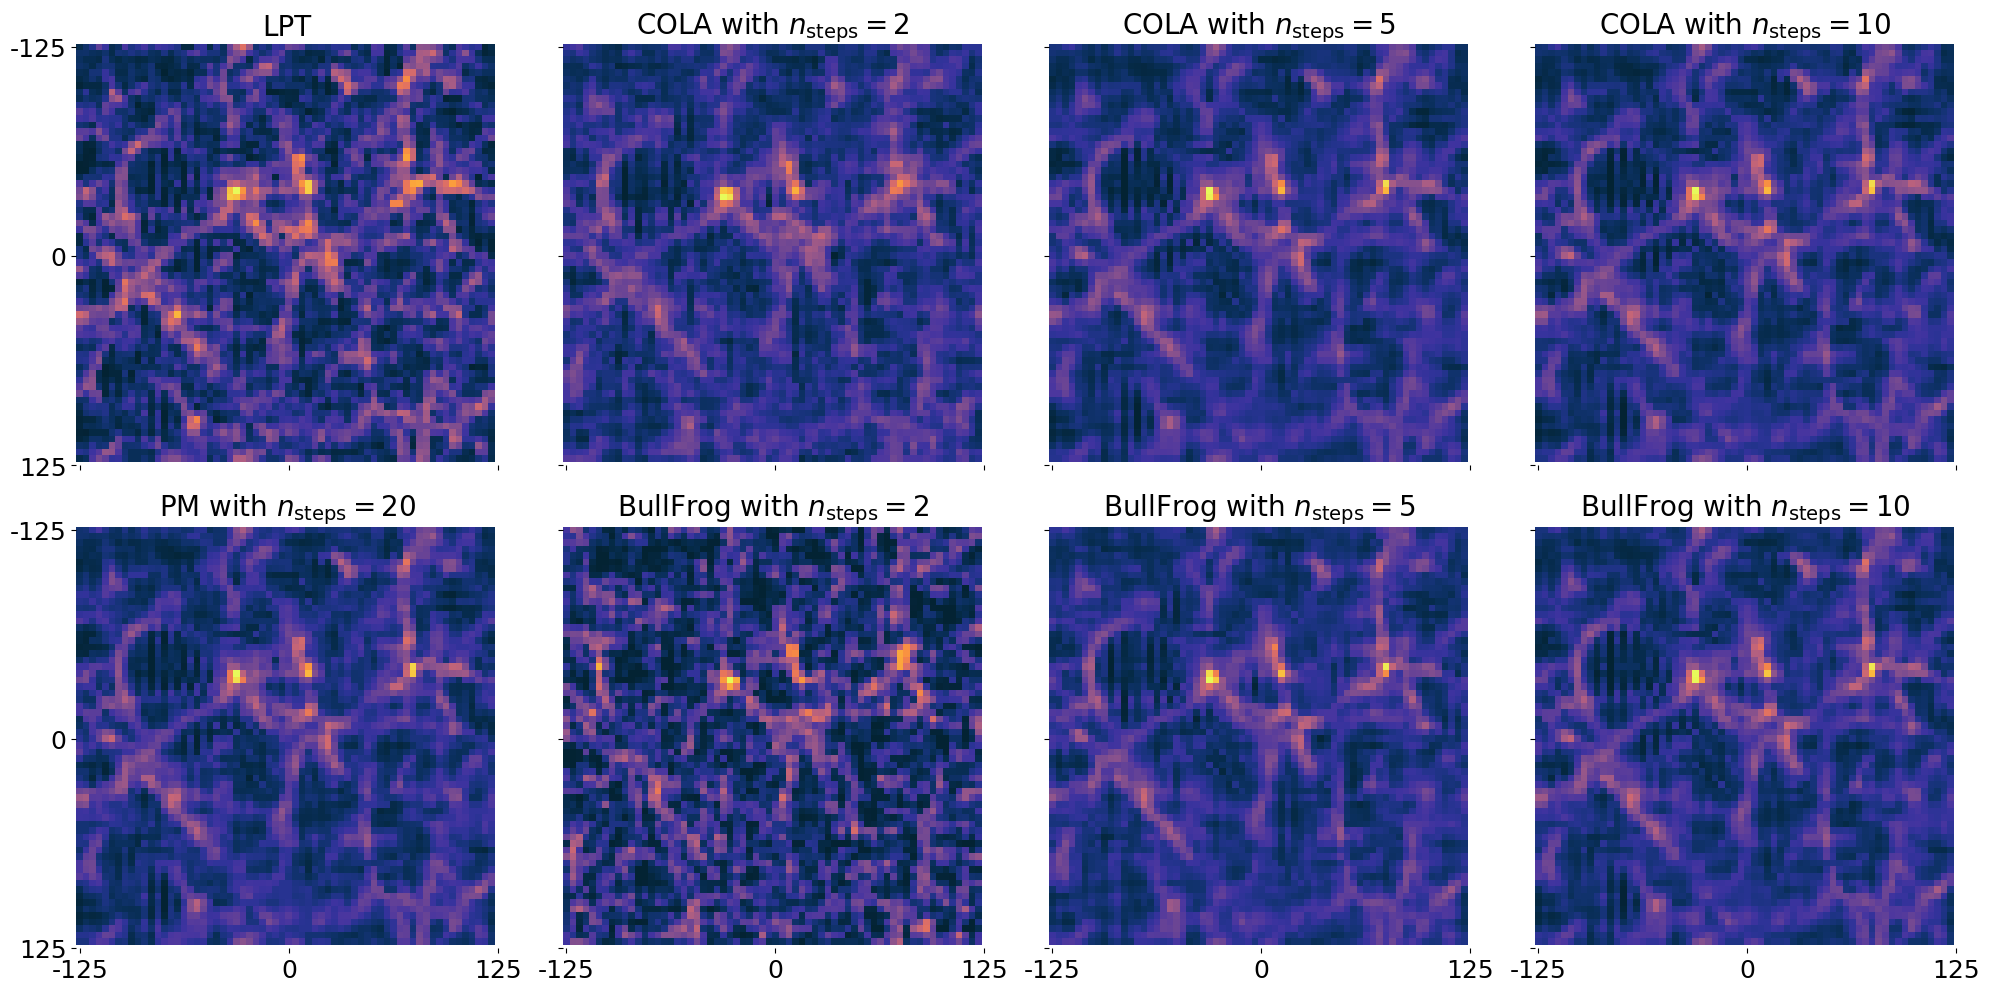

In [13]:
slice_ijk = (N//2, slice(None), slice(None))
DELTA_LPT = read_field(simdir + "lpt_density.h5").data[slice_ijk]

all_nsteps = sorted(list(set(nsteps_cola_list + nsteps_bullfrog_list)))[:4]

ncols = len(all_nsteps) + 1
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows), sharex=True, sharey=True)
axs[0, 0].imshow(np.log(2 + DELTA_LPT), cmap=cmap)
axs[0, 0].set_title("LPT", fontsize=fs_titles)
DELTA_PM = read_field(simdir + f"nsteps{max(nsteps_pm_list)}_final_density_pm.h5").data[slice_ijk]
axs[1, 0].imshow(np.log(2 + DELTA_PM), cmap=cmap)
axs[1, 0].set_title(f"PM with $n_\\mathrm{{steps}}={max(nsteps_pm_list)}$", fontsize=fs_titles)
for i, nsteps in enumerate(all_nsteps):
    if nsteps in nsteps_cola_list:
        DELTA_COLA = read_field(simdir + f"nsteps{nsteps}_final_density_cola.h5").data[slice_ijk]
        axs[0,i+1].imshow(np.log(2+DELTA_COLA), cmap=cmap)
        axs[0, i + 1].set_title(f"COLA with $n_\\mathrm{{steps}}={nsteps}$", fontsize=fs_titles)
    if nsteps in nsteps_bullfrog_list:
        DELTA_BULLFROG = read_field(simdir + f"nsteps{nsteps}_final_density_bullfrog.h5").data[slice_ijk]
        axs[1, i + 1].imshow(np.log(2 + DELTA_BULLFROG), cmap=cmap)
        axs[1,i+1].set_title(f"BullFrog with $n_\\mathrm{{steps}}={nsteps}$", fontsize=fs_titles)
for ax in axs.flatten():
    ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
for ax in axs[:,0]:
    ax.set_yticks([0, N//2, N])
    ax.set_yticklabels([f"{-L/2:.0f}", "0", f"{L/2:.0f}"], fontsize=fs)
for ax in axs[1,:]:
    ax.set_xticks([0, N//2, N])
    ax.set_xticklabels([f"{-L/2:.0f}", "0", f"{L/2:.0f}"], fontsize=fs)
for i in range(nrows):
    for j in range(ncols):
        if axs[i,j].get_title() == "":
            axs[i,j].axis("off")
plt.tight_layout()
plt.show()

### Compute and plot the power spectra of the evolved dark matter fields

In [14]:
G = read_FourierGrid(simdir + "input_ss_k_grid.h5")
k = G.k_modes[1:]
AliasingCorr = False

DELTA = read_field(simdir + "initial_density.h5")
Pk_INI, Vk_INI = get_autocorrelation(DELTA, G, False)
Pk_INI, Vk_INI = Pk_INI[1:], Vk_INI[1:]
Sk_INI = np.sqrt(Vk_INI)

DELTA = read_field(simdir + "lpt_density.h5")
Pk_LPT, Vk_LPT = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_LPT, Vk_LPT = Pk_LPT[1:], Vk_LPT[1:]
Sk_LPT = np.sqrt(Vk_LPT)

Pk_PM_list = []
Sk_PM_list = []
for nsteps in nsteps_pm_list:
    DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_pm.h5")
    Pk_PM, Vk_PM = get_autocorrelation(DELTA, G, AliasingCorr)
    Pk_PM, Vk_PM = Pk_PM[1:], Vk_PM[1:]
    Sk_PM = np.sqrt(Vk_PM)
    Pk_PM_list.append(Pk_PM)
    Sk_PM_list.append(Sk_PM)

Pk_ref = Pk_PM_list[-1]

Pk_COLA_list = []
Sk_COLA_list = []
for nsteps in nsteps_cola_list:
    DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_cola.h5")
    Pk_COLA, Vk_COLA = get_autocorrelation(DELTA, G, AliasingCorr)
    Pk_COLA, Vk_COLA = Pk_COLA[1:], Vk_COLA[1:]
    Sk_COLA = np.sqrt(Vk_COLA)
    Pk_COLA_list.append(Pk_COLA)
    Sk_COLA_list.append(Sk_COLA)

Pk_BULLFROG_list = []
Sk_BULLFROG_list = []
for nsteps in nsteps_bullfrog_list:
    DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_bullfrog.h5")
    Pk_BULLFROG, Vk_BULLFROG = get_autocorrelation(DELTA, G, AliasingCorr)
    Pk_BULLFROG, Vk_BULLFROG = Pk_BULLFROG[1:], Vk_BULLFROG[1:]
    Sk_BULLFROG = np.sqrt(Vk_BULLFROG)
    Pk_BULLFROG_list.append(Pk_BULLFROG)
    Sk_BULLFROG_list.append(Sk_BULLFROG)

[18:13:48|STATUS    ]|Read Fourier grid in data file '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_sims/run1/input_ss_k_grid.h5'...
[18:13:48|DIAGNOSTIC]==|L0=250.0, L1=250.0, L2=250.0
[18:13:48|DIAGNOSTIC]==|N0=64, N1=64, N2=64, N2_HC=33, N_HC=135168, NUM_MODES=50
[18:13:48|STATUS    ]|Read Fourier grid in data file '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_sims/run1/input_ss_k_grid.h5' done.
[18:13:48|STATUS    ]|Read field in data file '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_sims/run1/initial_density.h5'...
[18:13:48|DIAGNOSTIC]==|ranges=[np.float64(-125.0), np.float64(125.0), np.float64(-125.0), np.float64(125.0), np.float64(-125.0), np.float64(125.0), np.int32(64), np.int32(64), np.int32(64)]
[18:13:48|STATUS    ]|Read field in data file '/data101/hoellinger/BullFrog/comparisons_PM_BullFrog_COLA/tests/runs_sims/run1/initial_density.h5' done.
[18:13:48|STATUS    ]|Getting auto-correlation in Fourier s

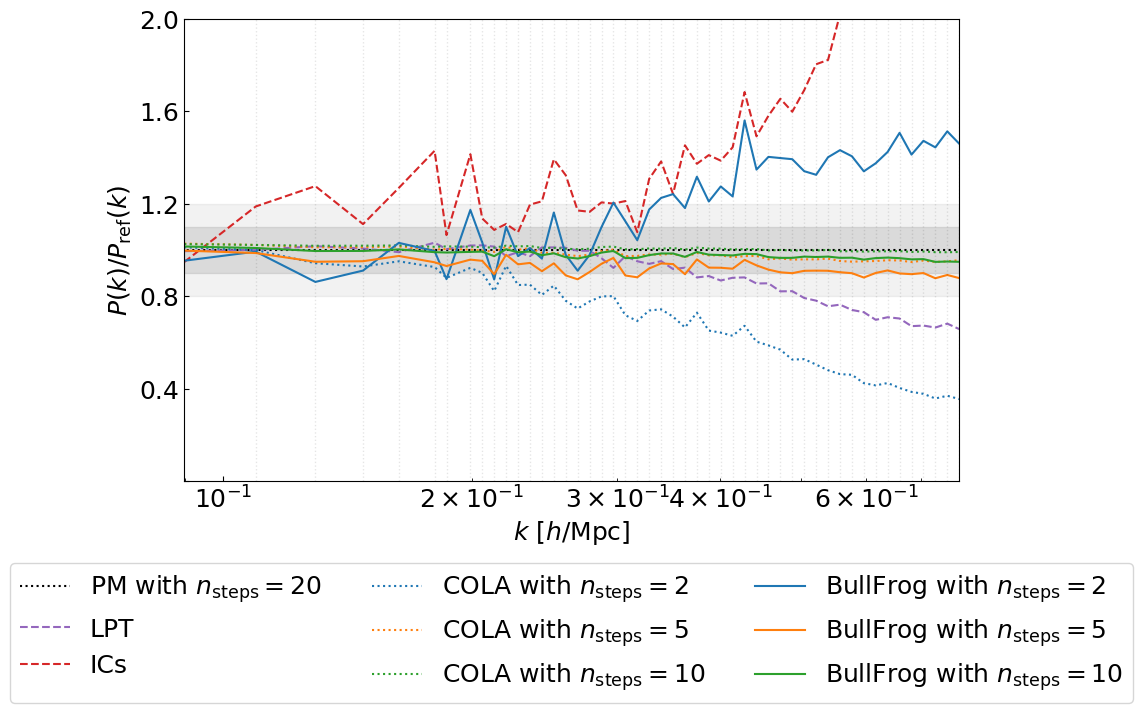

In [15]:
focused = True

common_nsteps = sorted(set(nsteps_cola_list).intersection(nsteps_bullfrog_list))
# common_nsteps = [nsteps for nsteps in common_nsteps if nsteps > 2]  # filter out first spectra
nlines = len(common_nsteps) + 2

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xscale("log")
k = G.k_modes[1:]
ax.set_xlim([k.min(), k.max()])
ax.set_ylim([0, 2])  # to be adjusted depending on the setup
bnd1 = 0.1  # to be adjusted depending on the setup
bnd2 = 0.2  # to be adjusted depending on the setup

label_ref = f"PM with $n_\\mathrm{{steps}}={max(nsteps_pm_list)}$"
line1 = ax.plot([1e-3, 1e1], [1, 1], color="black", linestyle=":", label=label_ref)
line2 = ax.plot(
    k, Pk_LPT / Pk_ref, label="LPT", color=cols[len(common_nsteps) + 1], linestyle="--"
)
line3 = ax.plot(k, Pk_INI / Pk_ref, label="ICs", color=cols[len(common_nsteps)], linestyle="--")
# line3 = None  # uncomment to hide ICs
for i, nsteps in enumerate(nsteps_pm_list[:-1]):
    ax.plot(
        k,
        Pk_PM_list[i] / Pk_ref,
        label=f"PM with $n_\\mathrm{{steps}}={nsteps}$",
        linestyle="--",
        color=cols[i],
    )
for i, nsteps in enumerate(common_nsteps):
    ax.plot(
        k,
        Pk_COLA_list[i] / Pk_ref,
        label=f"COLA with $n_\\mathrm{{steps}}={nsteps}$",
        linestyle=":",
        color=cols[i],
    )
for i, nsteps in enumerate(common_nsteps):
    ax.plot(
        k,
        Pk_BULLFROG_list[i] / Pk_ref,
        label=f"BullFrog with $n_\\mathrm{{steps}}={nsteps}$",
        linestyle="-",
        color=cols[i],
    )

ax.axhspan(1 - bnd1, 1 + bnd1, color="grey", alpha=0.2)
ax.axhspan(1 - bnd2, 1 + bnd2, color="grey", alpha=0.1)

# ax.grid(alpha=0.3)
for i in range(1, len(k)):
    ax.axvline(k[i], color="black", linestyle=":", linewidth=1, alpha=0.1)
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
ax.set_xlabel("$k$ [$h/\\mathrm{Mpc}$]", fontsize=fs)
ax.set_ylabel("$P(k)/P_\\mathrm{ref}(k)$", fontsize=fs)
ax.tick_params(which="both", direction="in")
ax.tick_params(axis="both", which="major", labelsize=fs)
ax.tick_params(axis="both", which="minor", labelsize=fs)
if line3 is None:
    empty_patch = mpatches.Patch(color="none", label="")
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = [empty_patch, *handles]
    labels = ["", *labels]
    plt.legend(
        handles,
        labels,
        loc="upper center",
        ncol=3,
        bbox_to_anchor=(0.5, -0.15),
        fontsize=fs,
    )
else:
    plt.legend(loc="upper center", ncol=3, bbox_to_anchor=(0.5, -0.15), fontsize=fs)

plt.show()

[13:57:15|STATUS    ]|Read timestepping configuration in 'runs_params/run0/nsteps10_ts_bullfrog.h5'...
[13:57:15|STATUS    ]|Read timestepping configuration in 'runs_params/run0/nsteps10_ts_bullfrog.h5' done.


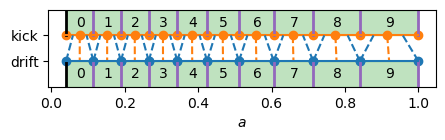

In [16]:
from pysbmy.timestepping import BullFrogTimeStepping

BullFrogTimeStepping.read("runs_params/run0/nsteps10_ts_bullfrog.h5").plot()